In [2]:
# import modules
import numpy as np # math
import astropy.units as u # units
from ReadFile import Read # we made this!
from CenterOfMass import CenterOfMass

 # plotting
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
%matplotlib inline
plt.rcParams['figure.dpi'] = 1200
plt.rcParams['savefig.dpi'] = 1200
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']}) # Computer Modern with TeX
rc('text', usetex=True)

# Constants
from astropy.constants import G
# adjust units
G = G.to(u.kpc * u.km**2 / u.s**2 / u.Msun)

# Mass Profile Class with Methods

In [3]:
class MassProfile:
    """
    Purpose: Creates a mass profile for a given galaxy snapshot. Includes methods to
    calculate enclosed masses, both from simulations and theoretical models, as well as 
    circular velocities for these simulation data and theoretical models.
    """
    
    
    def __init__(self, galaxy, snap):
        """
        Class to calculate the 6-D phase-space position of a galaxy's center of mass
        using a specified particle type.
        
            PARAMETERS
            ----------
            galaxy : 'str'
                Galaxy name, e.g. "MW", "M31", "M33"
            snap : 'int'
                Snapshot number, e.g. 0, 1, 2
        """
        # add a string of the filenumber to the value “000”
        ilbl = '000' + str(snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        
        # construct filename
        self.filename = '%s_'%(galaxy) + ilbl + '.txt'

        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             
        
        # store the masses and positions, of the particles
        self.m = self.data['m'] * 1e10 # data file given with masses as 1e10 Msun
        self.x = self.data['x'] * u.kpc
        self.y = self.data['y'] * u.kpc
        self.z = self.data['z'] * u.kpc
        self.r = np.sqrt(self.x**2 + self.y**2 +self.z**2) # Radius in kpc
        
        # store the name of the galaxy
        self.gname = galaxy
        
        
    def MassEnclosed(self, p_type, r):
        """
        Purpose: This method calculates the mass enclosed within a radius 'r' for particles
        of type 'p_type' in a galaxy.

        Inputs:
            p_type : 'int'
                1, 2, or 3 for Halo, Disk, or Bulge, respectively
            r : 'np.array'
                Array of radii (magnitudes) to calculate the enclosed masses at
        
        Returns:
            enclosed masses at radii in from 'r', with astropy quantity units of Msun
        """
        
        # Give the r array units so we can comapre properly
        r *= u.kpc
        
        # restrict to particles of type p_type                               
        type_x = self.x[np.where(self.data['type'] == p_type)]
        type_y = self.y[np.where(self.data['type'] == p_type)]
        type_z = self.z[np.where(self.data['type'] == p_type)]
        type_m = self.m[np.where(self.data['type'] == p_type)]
        
        # Create an instance of the CenterOfMass class
        com = CenterOfMass(self.filename, p_type)
        
        # Calculate the CoM with the COM_P method for CenterOfMass objects
        com_p = com.COM_P(0.1) # Error tolerance of 0.1 kpc (default, for us)
        
        # Shift to CoM frame
        x_new = type_x - com_p[0]
        y_new = type_y - com_p[1]
        z_new = type_z - com_p[2]
        # This is now an array of radii only of p_type, w.r.t. the galaxy's CoM.
        r_new = np.sqrt(x_new**2 + y_new**2 + z_new**2)
    
        # Determine the enclosed masses at all r_i in the 'r' array
        # Stored as an array of enclosed masses
        enc_masses = np.array( [np.sum(type_m[np.where(r_new < r_i)]) for r_i in r] )
    
        # Return the array of enclosed masses at the radii in 'r' with units, now
        return enc_masses * u.Msun
    
    
    def MassEnclosedTotal(self, r):
        """
        Purpose: This method calculates the total mass enclosed within a radius 'r'
        for all particles types in a galaxy (halo + disk + bulge).

        Inputs:
            r : 'np.array'
                Array of radii (magnitudes) to calculate the enclosed masses at
        
        Returns:
            total_mass : array of 'astropy quantity'
                Total mass enclosed at radii in 'r' for all particle types 
        """
        
        # call the MassEnclosed methods for all three types (only two for M33)
        if self.gname == 'M33':
            total_mass = np.add(*[self.MassEnclosed(i, r) for i in range(1,3)])
        else:
            total_mass = np.add(*[self.MassEnclosed(i, r) for i in range(1,4)])
            
        # Return the total enclosed mass for all galaxy components
        return total_mass
    
    
    def HernquistMass(self, r, a, Mhalo):
        """
        Purpose: calculates a theoretical mass profile based on the Hernquist profile.
        
        Inputs:
            r : 'np.array'
                Array of radii (magnitudes) to calculate the enclosed masses at
            a : 'float' or 'int'
                Hernquist profile scale factor in kpc (no astropy quantity units, though)
            Mhalo : 'float' or 'int'
                Total halo mass in Msun (no astropy quantity units, though)
                
        Returns:
            Hernquist profile enclosed mass vector with astropy quantity units of Msun
        """
        
        # Calculate from the formula for the Hernquist profile
        hernquist = Mhalo * r**2 / (a + r)**2
        # Return the resultant vector
        return hernquist * u.Msun
    
    
    def CircularVelocity(self, p_type, r):
        """
        Purpose: Calculates the circular speed at radii in 'r' for particle type
        p_type, assuming spherical symmetry.
        
         Inputs:
            p_type : 'int'
                1, 2, or 3 for Halo, Disk, or Bulge, respectively
            r : 'np.array'
                Array of radii (magnitudes) to calculate the enclosed masses at
        
        Returns:
            v_c: array of circular speeds in km/s (astropy quantity) at radii in r
        """
        
        # Enclosed mass with the MassEnclosed method (at array of r-values)
        M_enc = self.MassEnclosed(p_type, r)
        r *= u.kpc # give r units
        v_c = np.sqrt(G * M_enc / r) # Calculate circular speed
        
        # return the result
        return v_c
    
    def TotalCircularVelocity(self, r):
        """
        Purpose: Calculates the circular speed at radii in 'r' for all particles,
        assuming spherical symmetry.
        
         Inputs:
            r : 'np.array'
                Array of radii (magnitudes) to calculate the enclosed masses at.
        
        Returns:
            v_c: array of circular speeds in km/s (astropy quantity) at radii in 'r'.
        """
        
        # Total enclosed mass with the MassEnclosedTotal method (at array of r-values)
        M_enc = self.MassEnclosedTotal(r)
        r *= u.kpc # give r units
        v_c = np.sqrt(G * M_enc / r) # Calculate circular speed
        
        # return the result
        return v_c
    
    
    def HernquistVCirc(self, r, a, Mhalo):
        """
        Purpose: Calculates the circular speed at radii in 'r' for the Hernquist
        mass profile.
        
         Inputs:
            r : 'np.array'
                Array of radii (magnitudes) to calculate the enclosed masses at
            a : 'float' or 'int'
                Hernquist profile scale factor in kpc (no astropy quantity units, though)
            Mhalo : 'float' or 'int'
                Total halo mass in Msun (no astropy quantity units, though)
        
        Returns:
            v_c: array of circular speeds in km/s (astropy quantity) at radii in 'r'.
        """
        
        # Enclosed mass with the HernquistMass method (at array of r-values)
        M_enc = self.HernquistMass(r, a, Mhalo)
        r *= u.kpc # give r units
        v_c = np.sqrt(G * M_enc / r) # Calculate circular speed
       
        # return the result, rounded to two decimal places
        return np.round(v_c, 2)

``MassEnclosed`` testing:

In [4]:
MW = MassProfile("MW", 0) # initialize the MassProfile class for MW
r = np.arange(0.25, 30.5, 1.5); # create an array of radii as the input
MW.MassEnclosed(1, r) # get the enclosed halo masses at each element in 'r'

<Quantity [0.00000000e+00, 1.18495500e+09, 4.77931850e+09, 9.12415350e+09,
           1.57204030e+10, 2.36991000e+10, 3.14013075e+10, 4.08809475e+10,
           5.29279900e+10, 6.37110805e+10, 7.59951140e+10, 8.82396490e+10,
           1.02340614e+11, 1.15730605e+11, 1.29871068e+11, 1.44209024e+11,
           1.59494943e+11, 1.73121926e+11, 1.85998437e+11, 1.99269933e+11,
           2.12620426e+11] solMass>

``MassEnclosedTotal`` testing:

In [5]:
MW.MassEnclosedTotal(r)

<Quantity [7.96000000e+08, 2.02899550e+10, 3.47573185e+10, 4.66931535e+10,
           5.91594030e+10, 7.16571000e+10, 8.32703075e+10, 9.65879475e+10,
           1.12101990e+11, 1.26167081e+11, 1.41105114e+11, 1.55775649e+11,
           1.71823614e+11, 1.86723605e+11, 2.02001068e+11, 2.17192024e+11,
           2.33131943e+11, 2.47259926e+11, 2.60442437e+11, 2.73951933e+11,
           2.87521426e+11] solMass>

``HernquistMass`` testing:

In [6]:
# Test with arbitrary, but OoM values.
MW.HernquistMass(r, 17, 1e12)

<Quantity [2.10039908e+08, 8.71111111e+09, 2.57582686e+10, 4.76945435e+10,
           7.22626893e+10, 9.80512193e+10, 1.24172336e+11, 1.50068988e+11,
           1.75396304e+11, 1.99947121e+11, 2.23604351e+11, 2.46310014e+11,
           2.68044867e+11, 2.88814846e+11, 3.08641975e+11, 3.27558245e+11,
           3.45601469e+11, 3.62812489e+11, 3.79233298e+11, 3.94905790e+11,
           4.09870944e+11] solMass>

``CircularVelocity`` testing:

In [7]:
MW.CircularVelocity(1, r)

<Quantity [  0.        ,  53.96503325,  79.52832776,  90.89291486,
           104.00934785, 114.6820955 , 120.83243959, 127.8900593 ,
           136.31862623, 141.16813609, 146.39911722, 150.52374837,
           155.30059443, 158.75269482, 162.12772296, 165.11482247,
           168.18921044, 170.0466046 , 171.33730751, 172.65633058,
           173.8682754 ] km / s>

``TotalCircularVelocity`` testing:

In [8]:
MW.TotalCircularVelocity(r)

<Quantity [117.02188081, 223.30685853, 214.46775006, 205.61762687,
           201.76806409, 199.41568156, 196.76813179, 196.57929851,
           198.38971846, 198.65624498, 199.48810256, 199.99674311,
           201.22898382, 201.64924774, 202.19849094, 202.63374905,
           203.34128539, 203.22109857, 202.7464067 , 202.44115389,
           202.18687571] km / s>

``HernquistVCirc`` testing:

In [9]:
# Test with arbitrary, but OoM values.
MW.HernquistVCirc(r, 17, 1e12)

<Quantity [ 60.11, 146.32, 184.63, 207.81, 223.  , 233.27, 240.28, 245.03,
           248.15, 250.08, 251.12, 251.49, 251.33, 250.79, 249.94, 248.85,
           247.58, 246.17, 244.65, 243.06, 241.4 ] km / s>

# 8 &nbsp; Mass Profile Plots

### Milky Way:

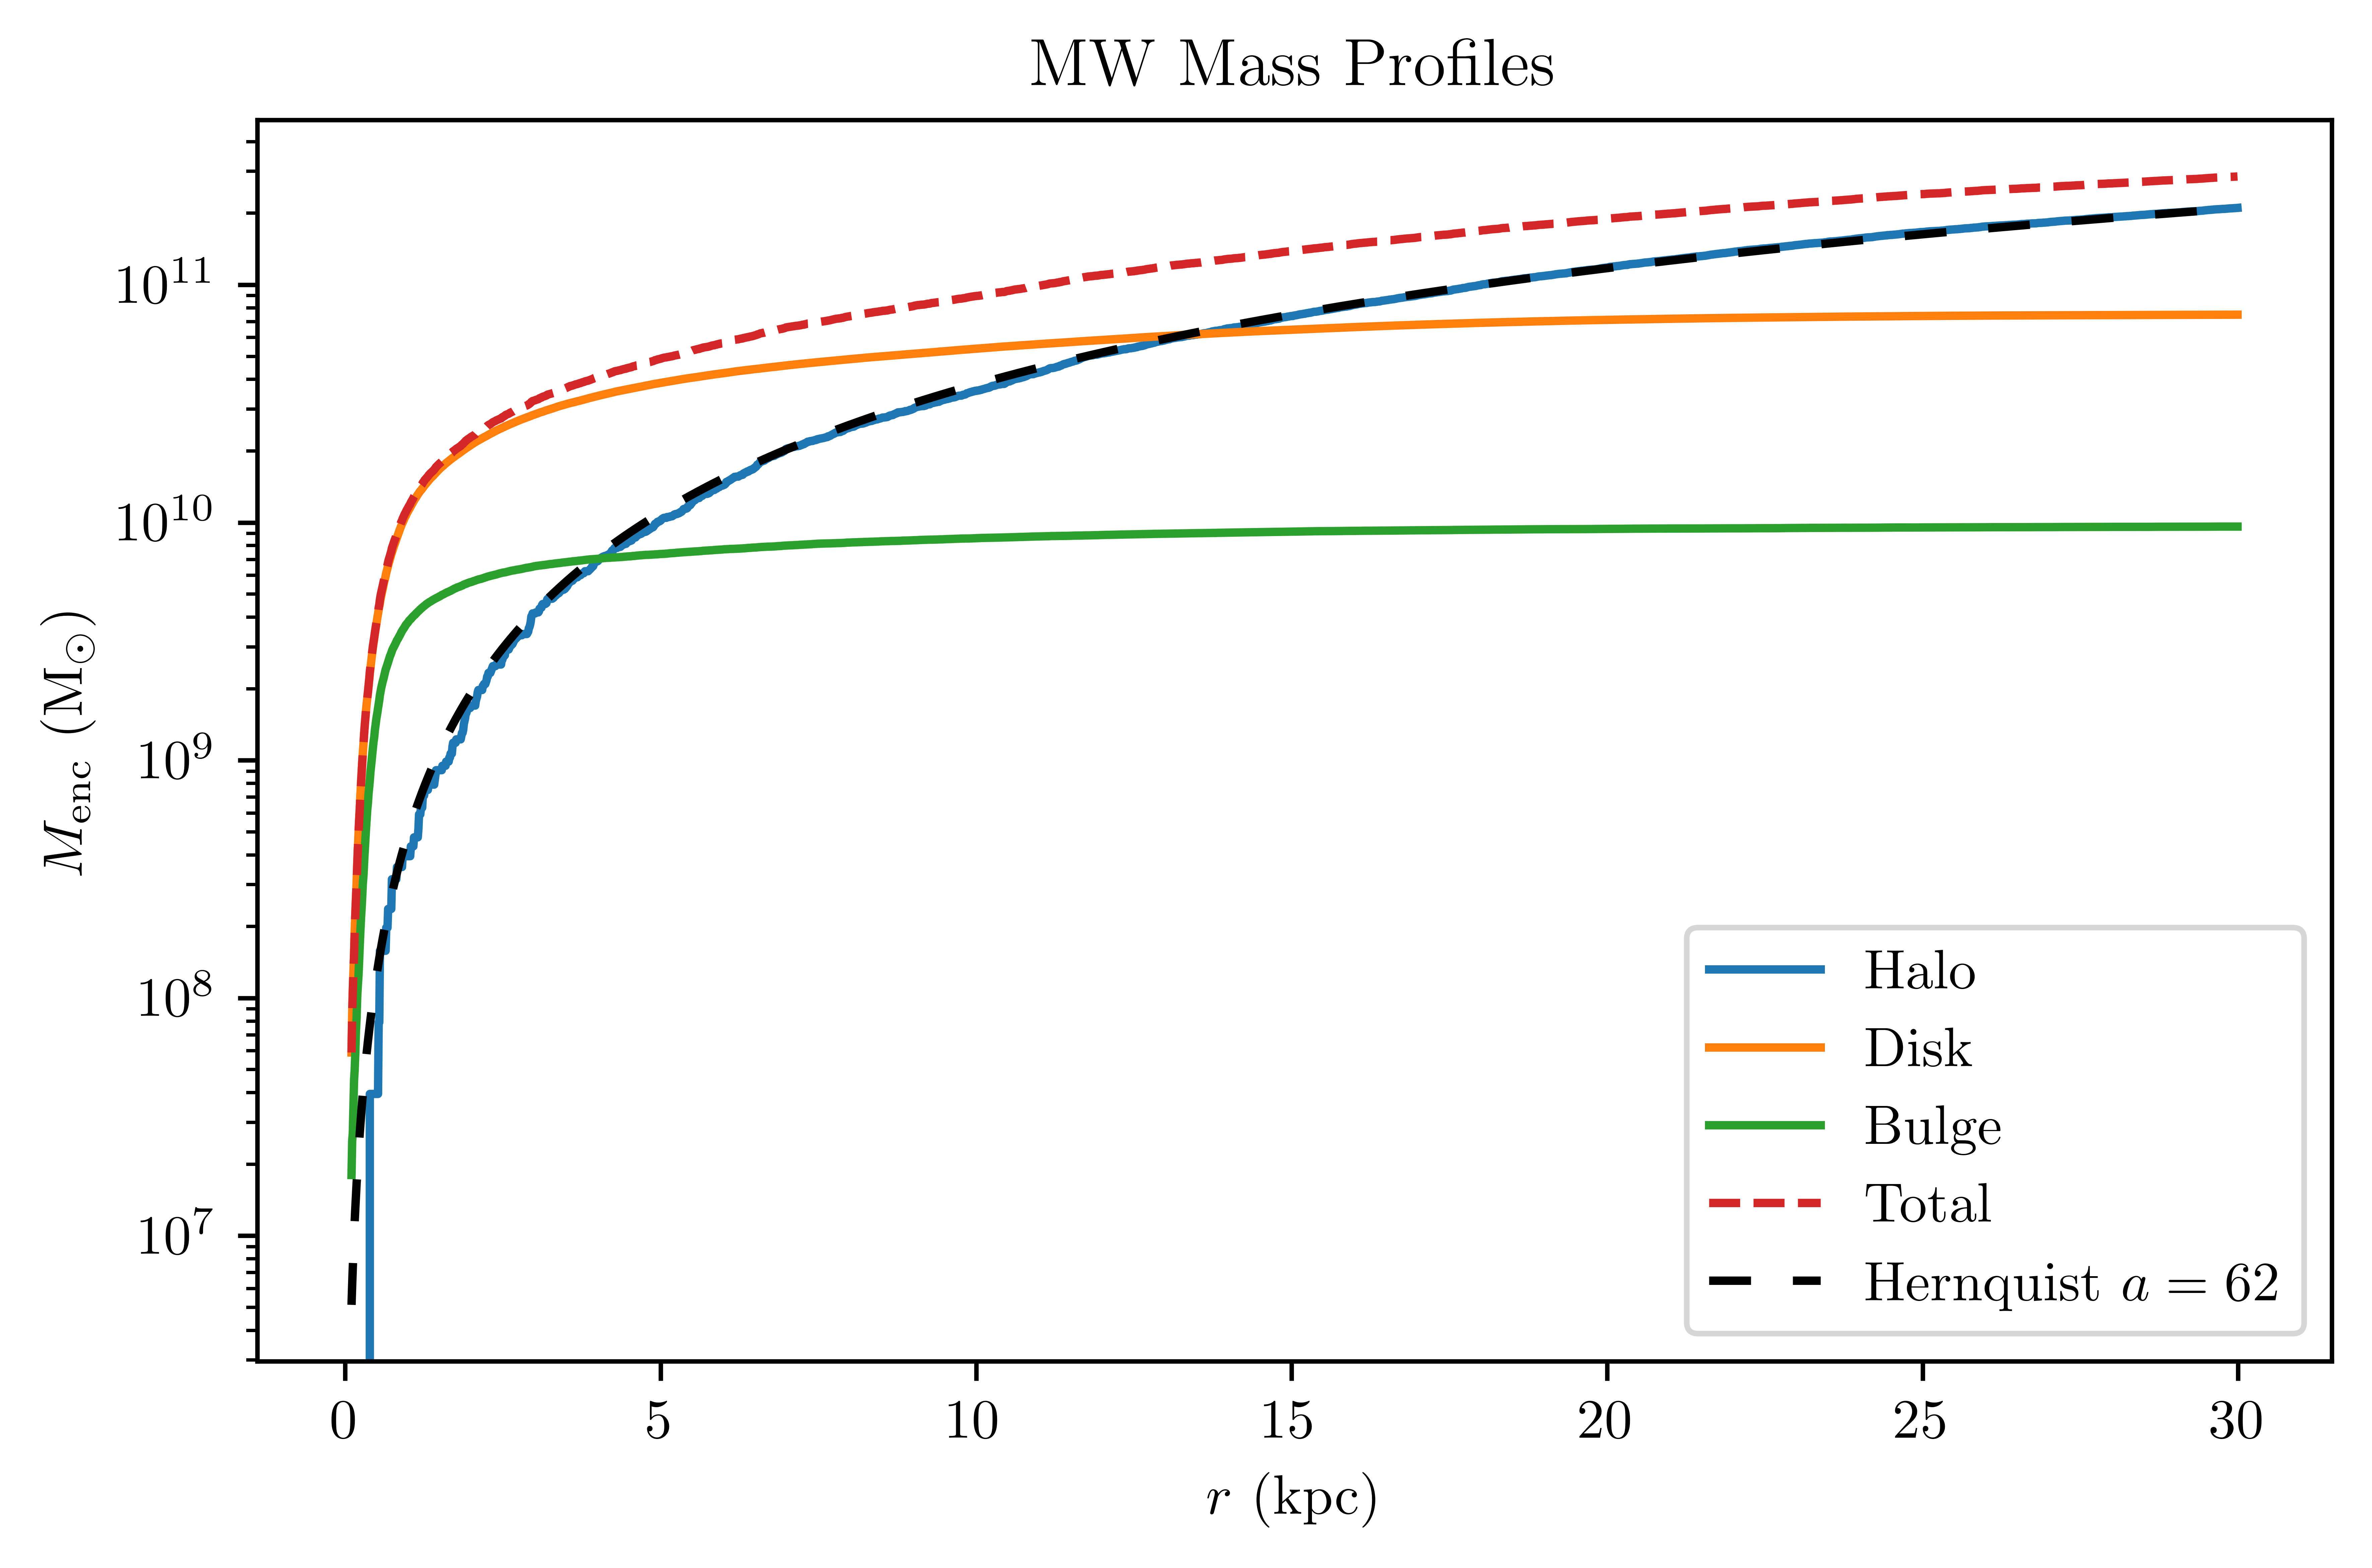

In [17]:
# Setup for plot
fig, ax = plt.subplots()

# 0.1 to 30 kpc in steps of 0.01 kpc
radii = np.arange(0.1, 30, 0.01)

# Loop through and plot for the different particles (log y-axis)
types = ['Halo', 'Disk', 'Bulge'] # Labels
for i in range(1, 4):
    ax.semilogy(radii, MW.MassEnclosed(i, radii), label=f'{types[i-1]}')

# Plot the total mass
ax.semilogy(radii, MW.MassEnclosedTotal(radii), label='Total', linestyle='--')
    
# Plot the best-fit Hernquist profile
# Total DM halo mass for the MW
MW_halo = np.sum(MW.m[np.where(MW.data['type'] == 1)])
a_best_MW = 62 # Best-ft scale radius
ax.semilogy(radii, MW.HernquistMass(radii, a_best_MW, MW_halo),
            label=r'Hernquist $a={}$'.format(a_best_MW),
            linestyle=(0, (5, 5)), color='k', linewidth=1.5)

# Legend, labels/title
ax.legend()
ax.set(title=r'MW Mass Profiles', xlabel=r"$r \ (\mathrm{kpc})$",
       ylabel=r'$M_\mathrm{enc} \ (\mathrm{M_\odot})$')

# Tidy things up and save the figure as a PNG
fig.tight_layout()
plt.savefig('MW_mass_profiles.png', facecolor='white')

### M33:

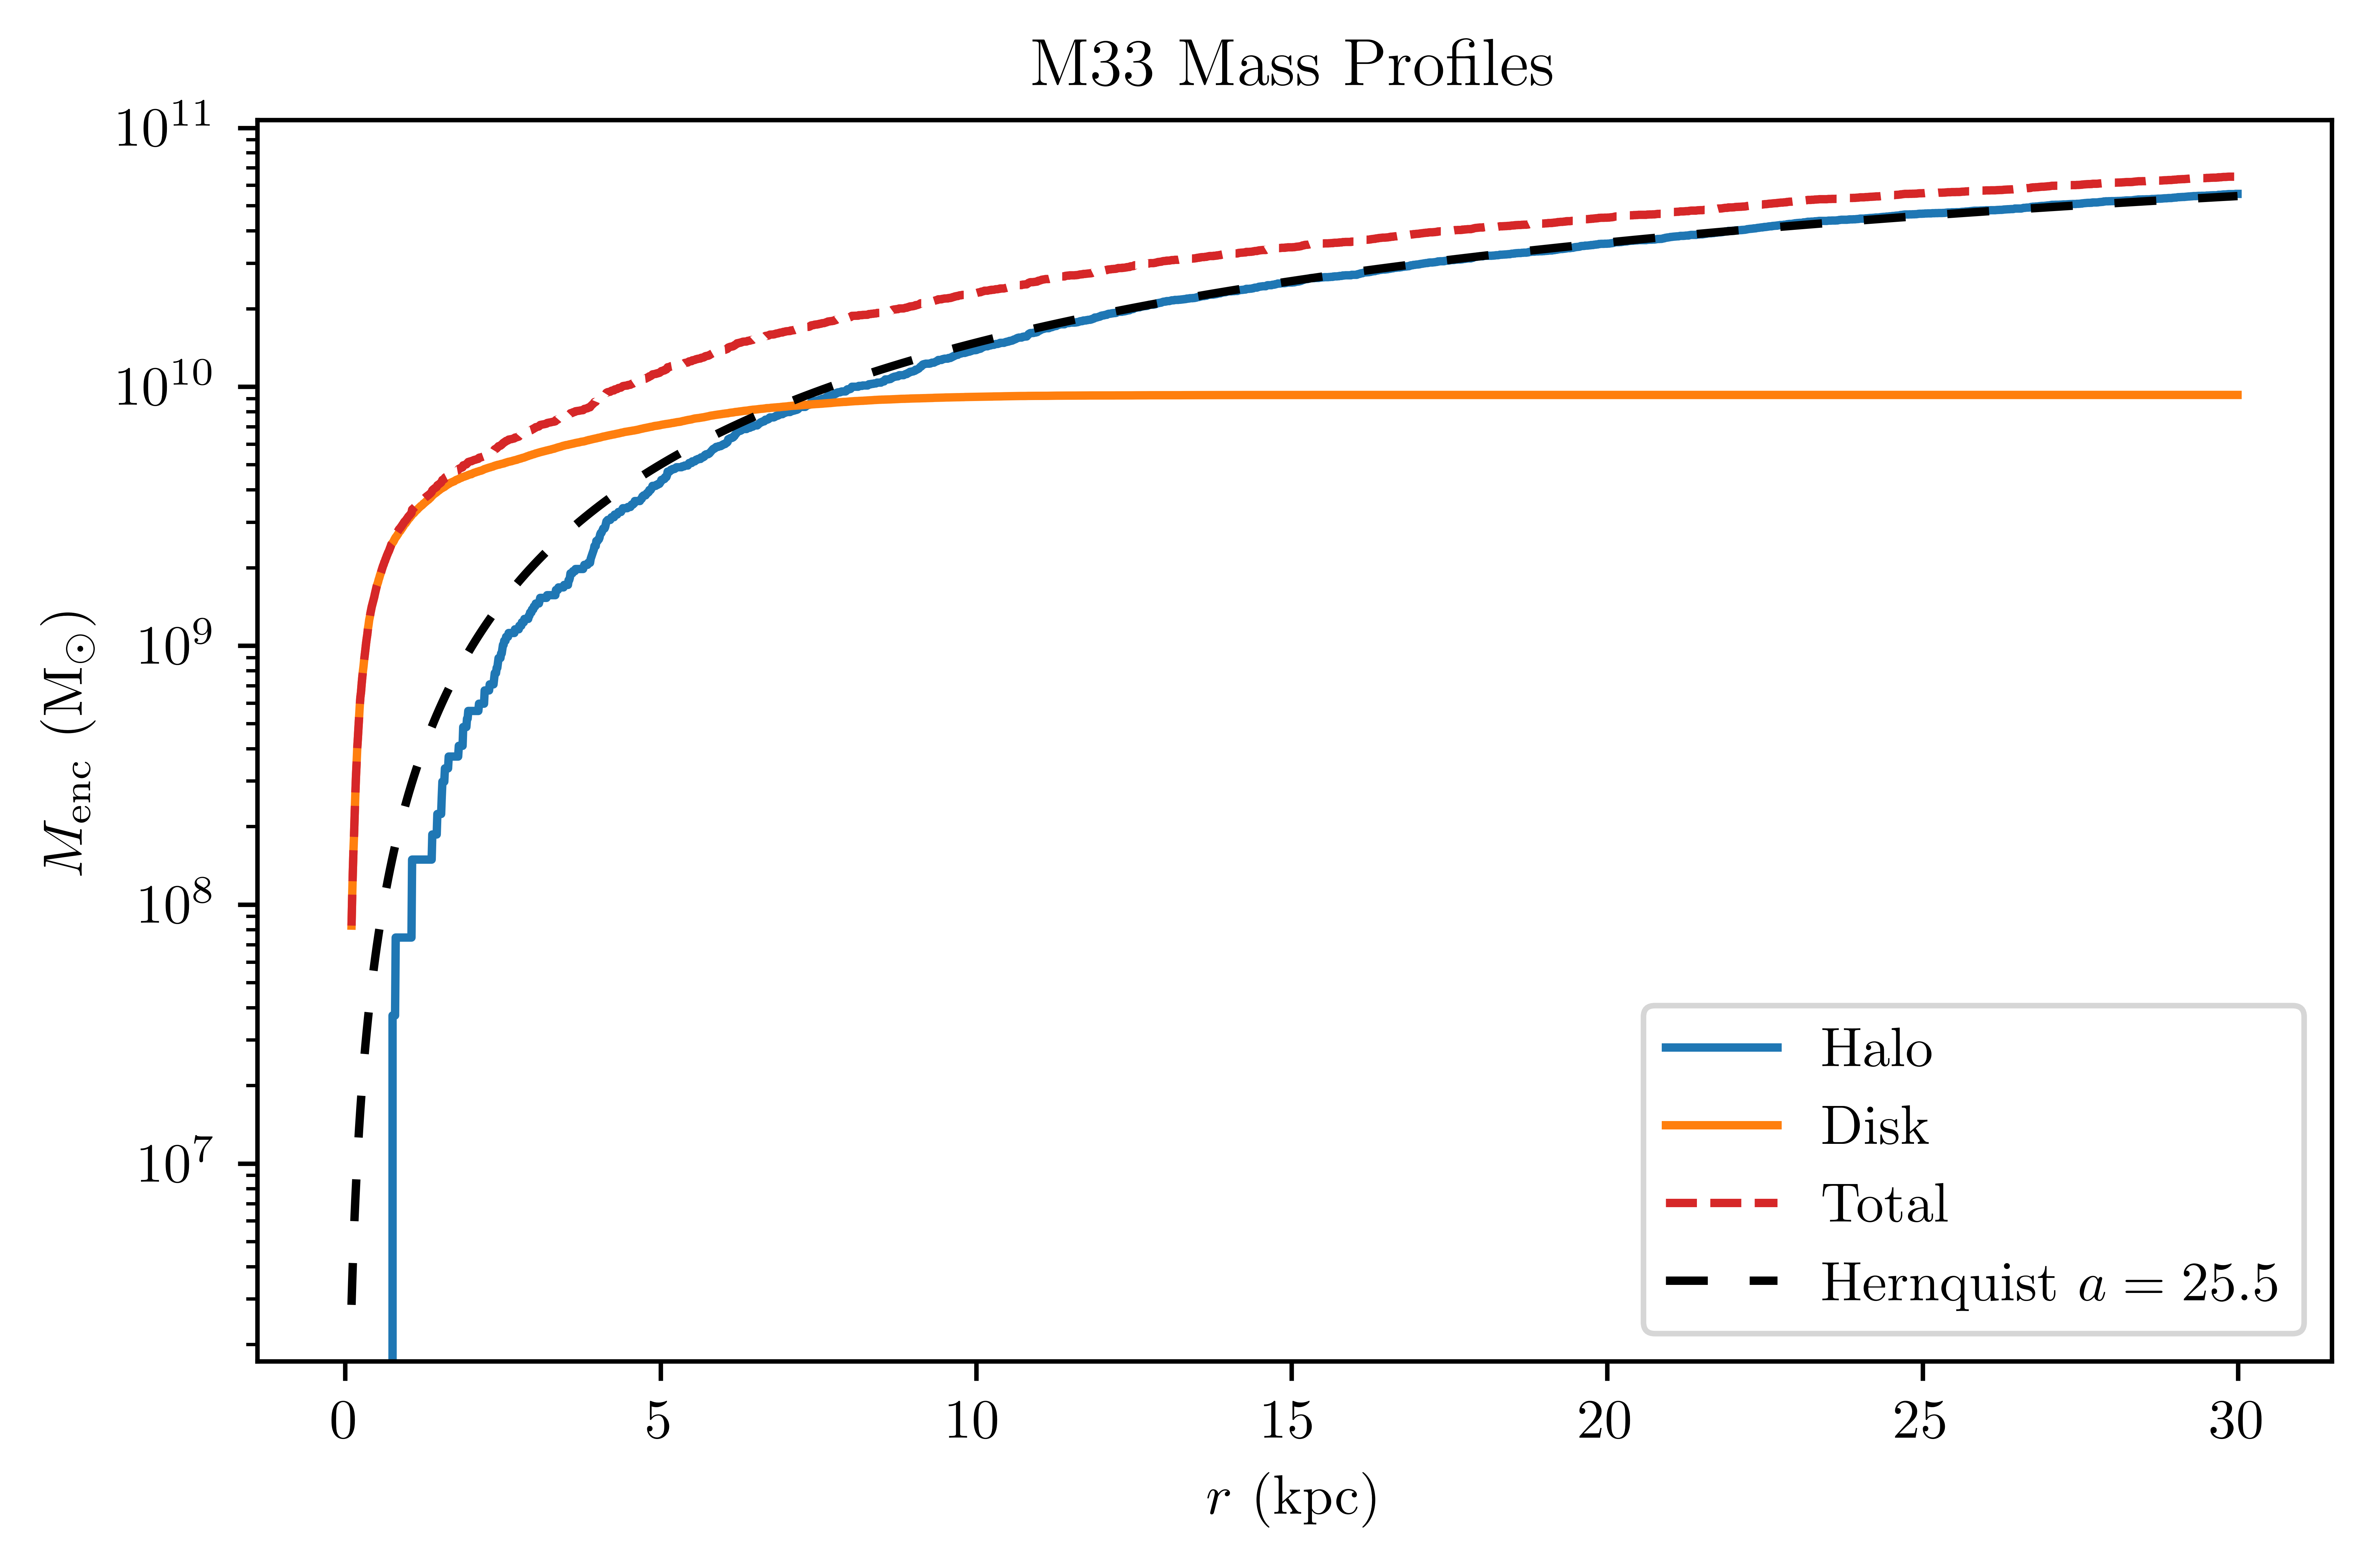

In [22]:
# initialize an instance of the MassProfile class for M33
M33 = MassProfile("M33", 0)

# Setup for plot
fig, ax = plt.subplots()

# Loop through and plot for the different particles (log y-axis), no bulge
for i in range(1, 3):
    ax.semilogy(radii, M33.MassEnclosed(i, radii), label=f'{types[i-1]}')

# Plot the total mass
ax.semilogy(radii, M33.MassEnclosedTotal(radii), label='Total', linestyle='--',
           color='C3') # Change color to match other mass profiles with bulge
    
# Plot the best-fit Hernquist profile
# Total DM halo mass for M33
M33_halo = np.sum(M33.m[np.where(M33.data['type'] == 1)])
a_best_M33 = 25.5 # best-fit Hernquist scale radius
ax.semilogy(radii, M33.HernquistMass(radii, a_best_M33, M33_halo),
            label=r'Hernquist $a = {}$'.format(a_best_M33),
            linestyle=(0, (5, 5)), color='k', linewidth=1.5)

# Legend, labels/title
ax.legend()
ax.set(title=r'M33 Mass Profiles', xlabel=r"$r \ (\mathrm{kpc})$",
       ylabel=r'$M_\mathrm{enc} \ (\mathrm{M_\odot})$')
# Tidy things up and save the figure as a PNG
fig.tight_layout()
plt.savefig('M33_mass_profiles.png', facecolor='white')

### M31 Mass Profiles:

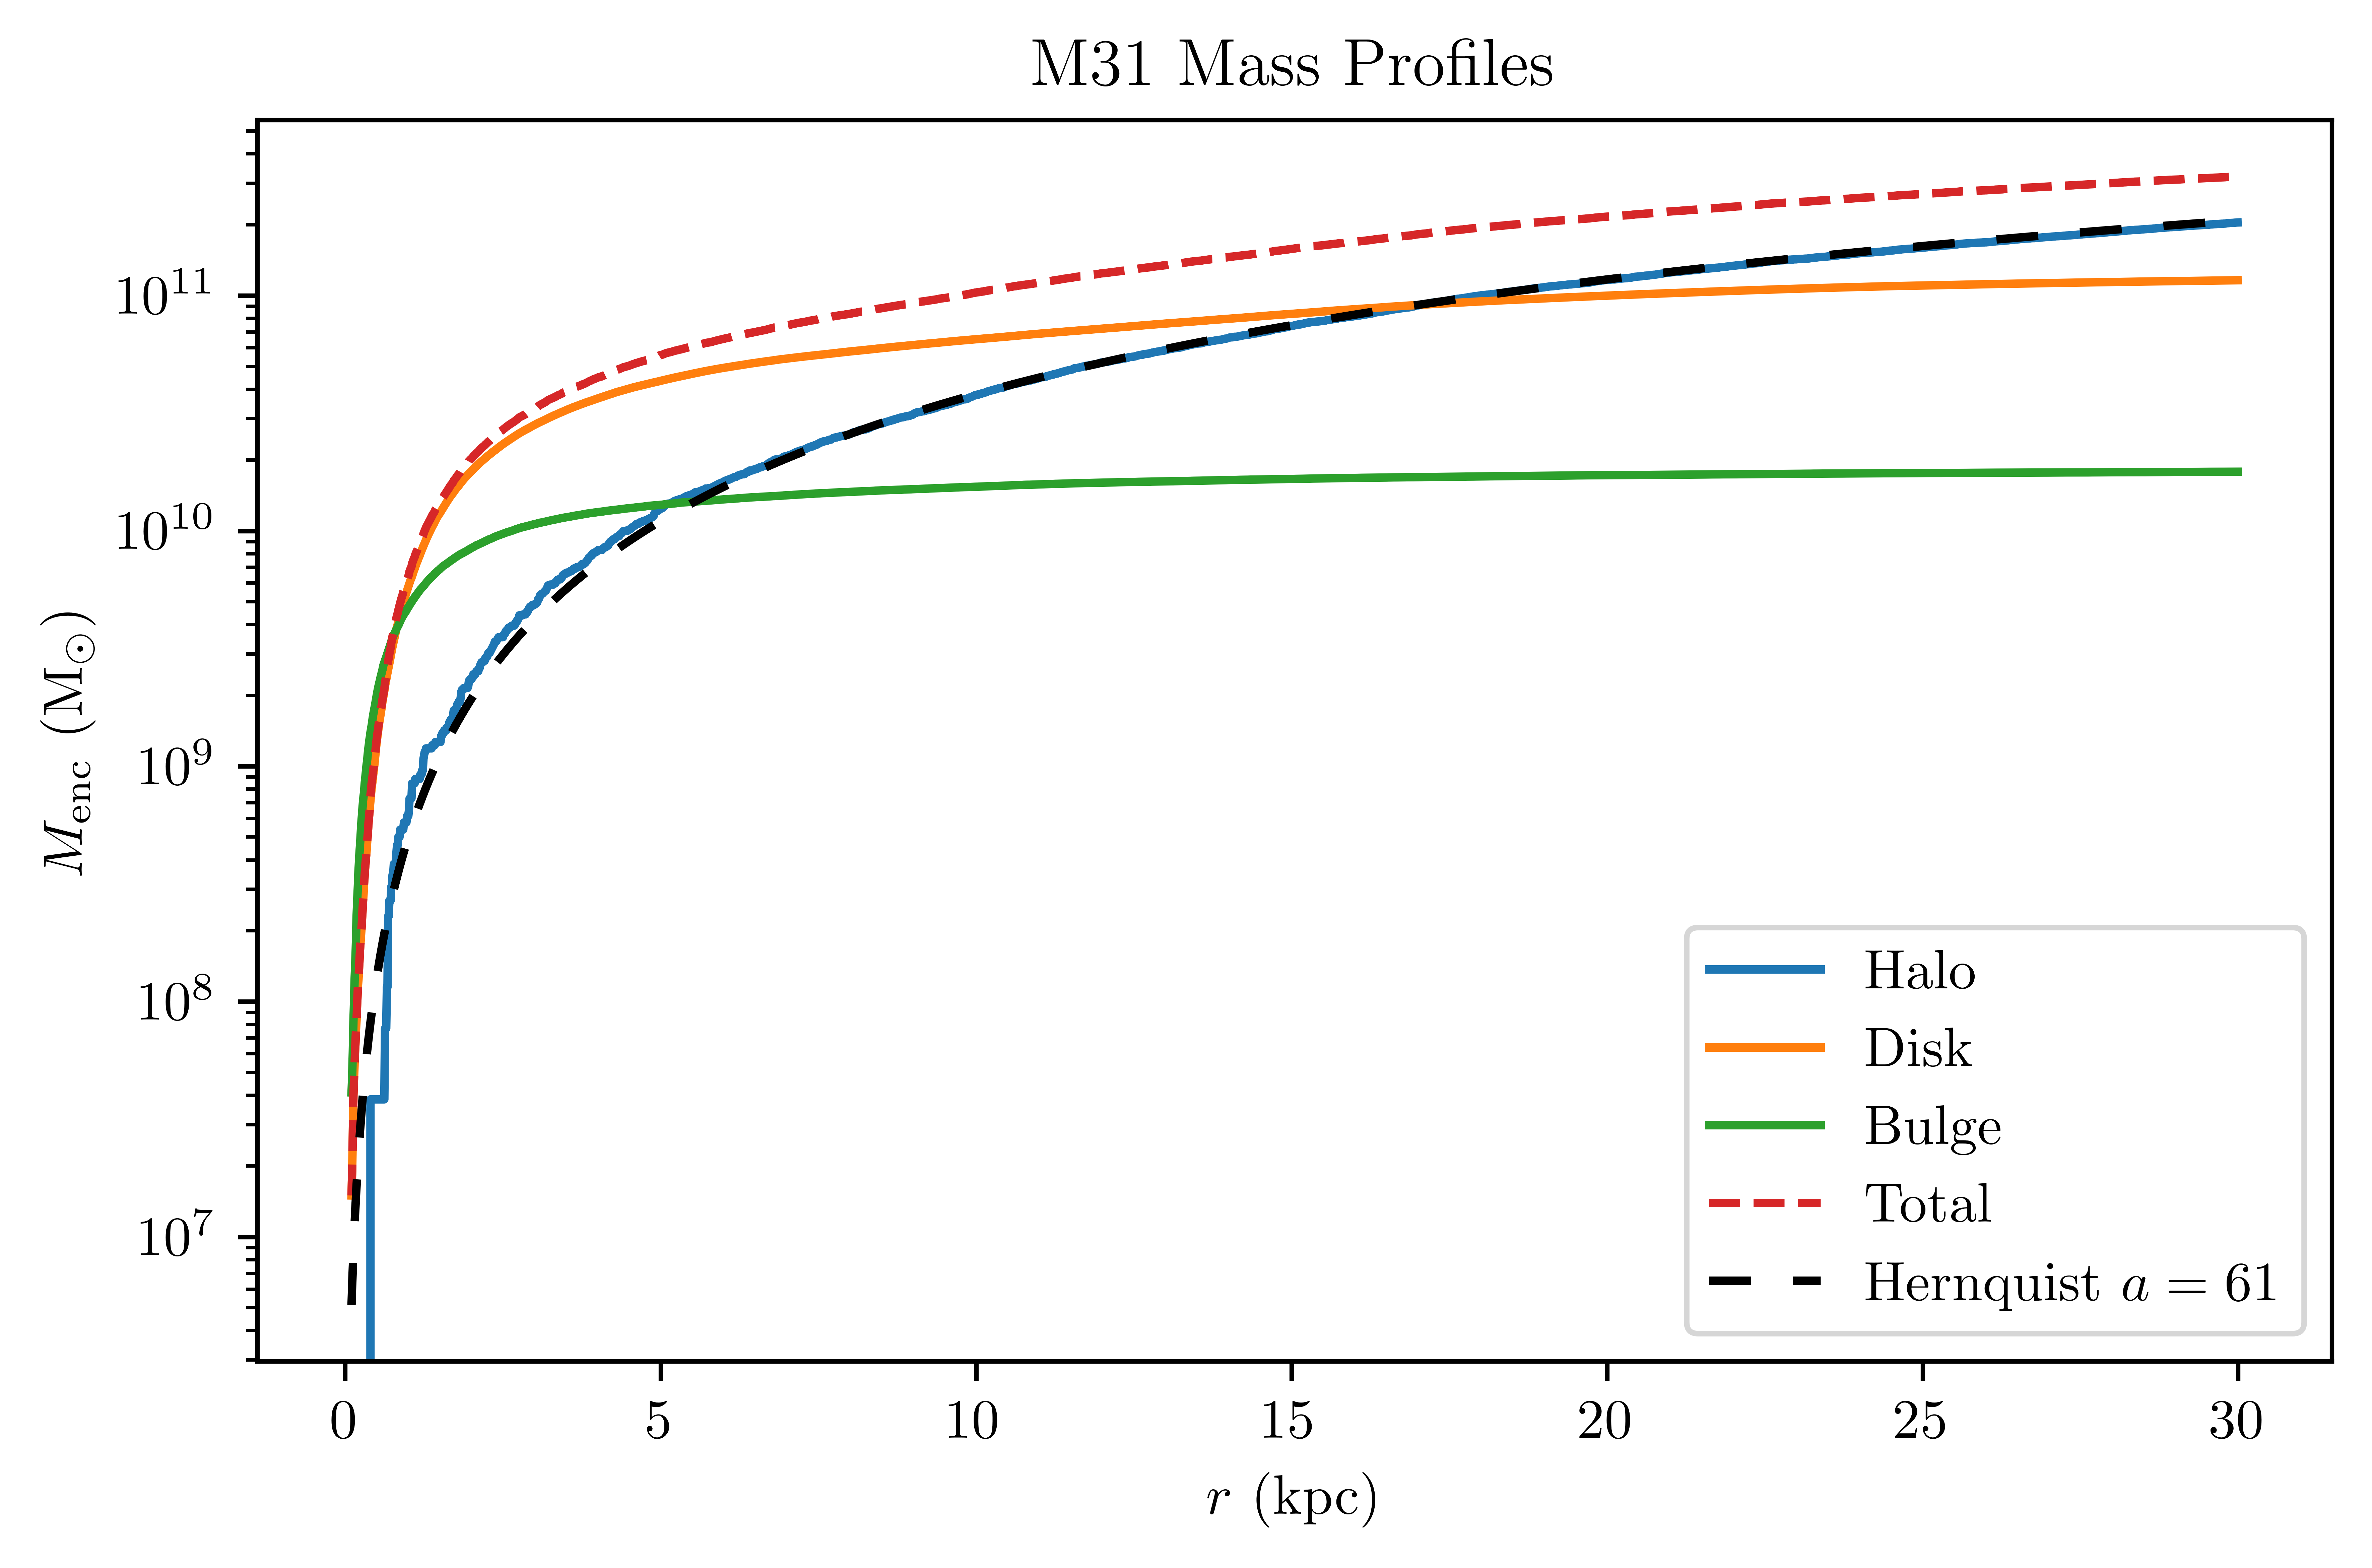

In [23]:
# initialize an instance of the MassProfile class for M31
M31 = MassProfile("M31", 0)

# Setup for plot
fig, ax = plt.subplots()

# Loop through and plot for the different particles (log y-axis)
types = ['Halo', 'Disk', 'Bulge'] # Labels
for i in range(1, 4):
    ax.semilogy(radii, M31.MassEnclosed(i, radii), label=f'{types[i-1]}')

# Plot the total mass
ax.semilogy(radii, M31.MassEnclosedTotal(radii), label='Total', linestyle='--')
    
# Plot the best-fit Hernquist profile
# Total DM halo mass for M31
M31_halo = np.sum(M31.m[np.where(M31.data['type'] == 1)])
a_best_M31 = 61
ax.semilogy(radii, M31.HernquistMass(radii, a_best_M31, M31_halo),
            label=r'Hernquist $a = {}$'.format(a_best_M31),
            linestyle=(0, (5, 5)), color='k', linewidth=1.5)

# Legend, labels/title
ax.legend()
ax.set(title=r'M31 Mass Profiles', xlabel=r"$r \ (\mathrm{kpc})$",
       ylabel=r'$M_\mathrm{enc} \ (\mathrm{M_\odot})$')

# Tidy things up and save the figure as a PNG
fig.tight_layout()
plt.savefig('M31_mass_profiles.png', facecolor='white')

# 8 &nbsp; Rotation Curves:

### MW:

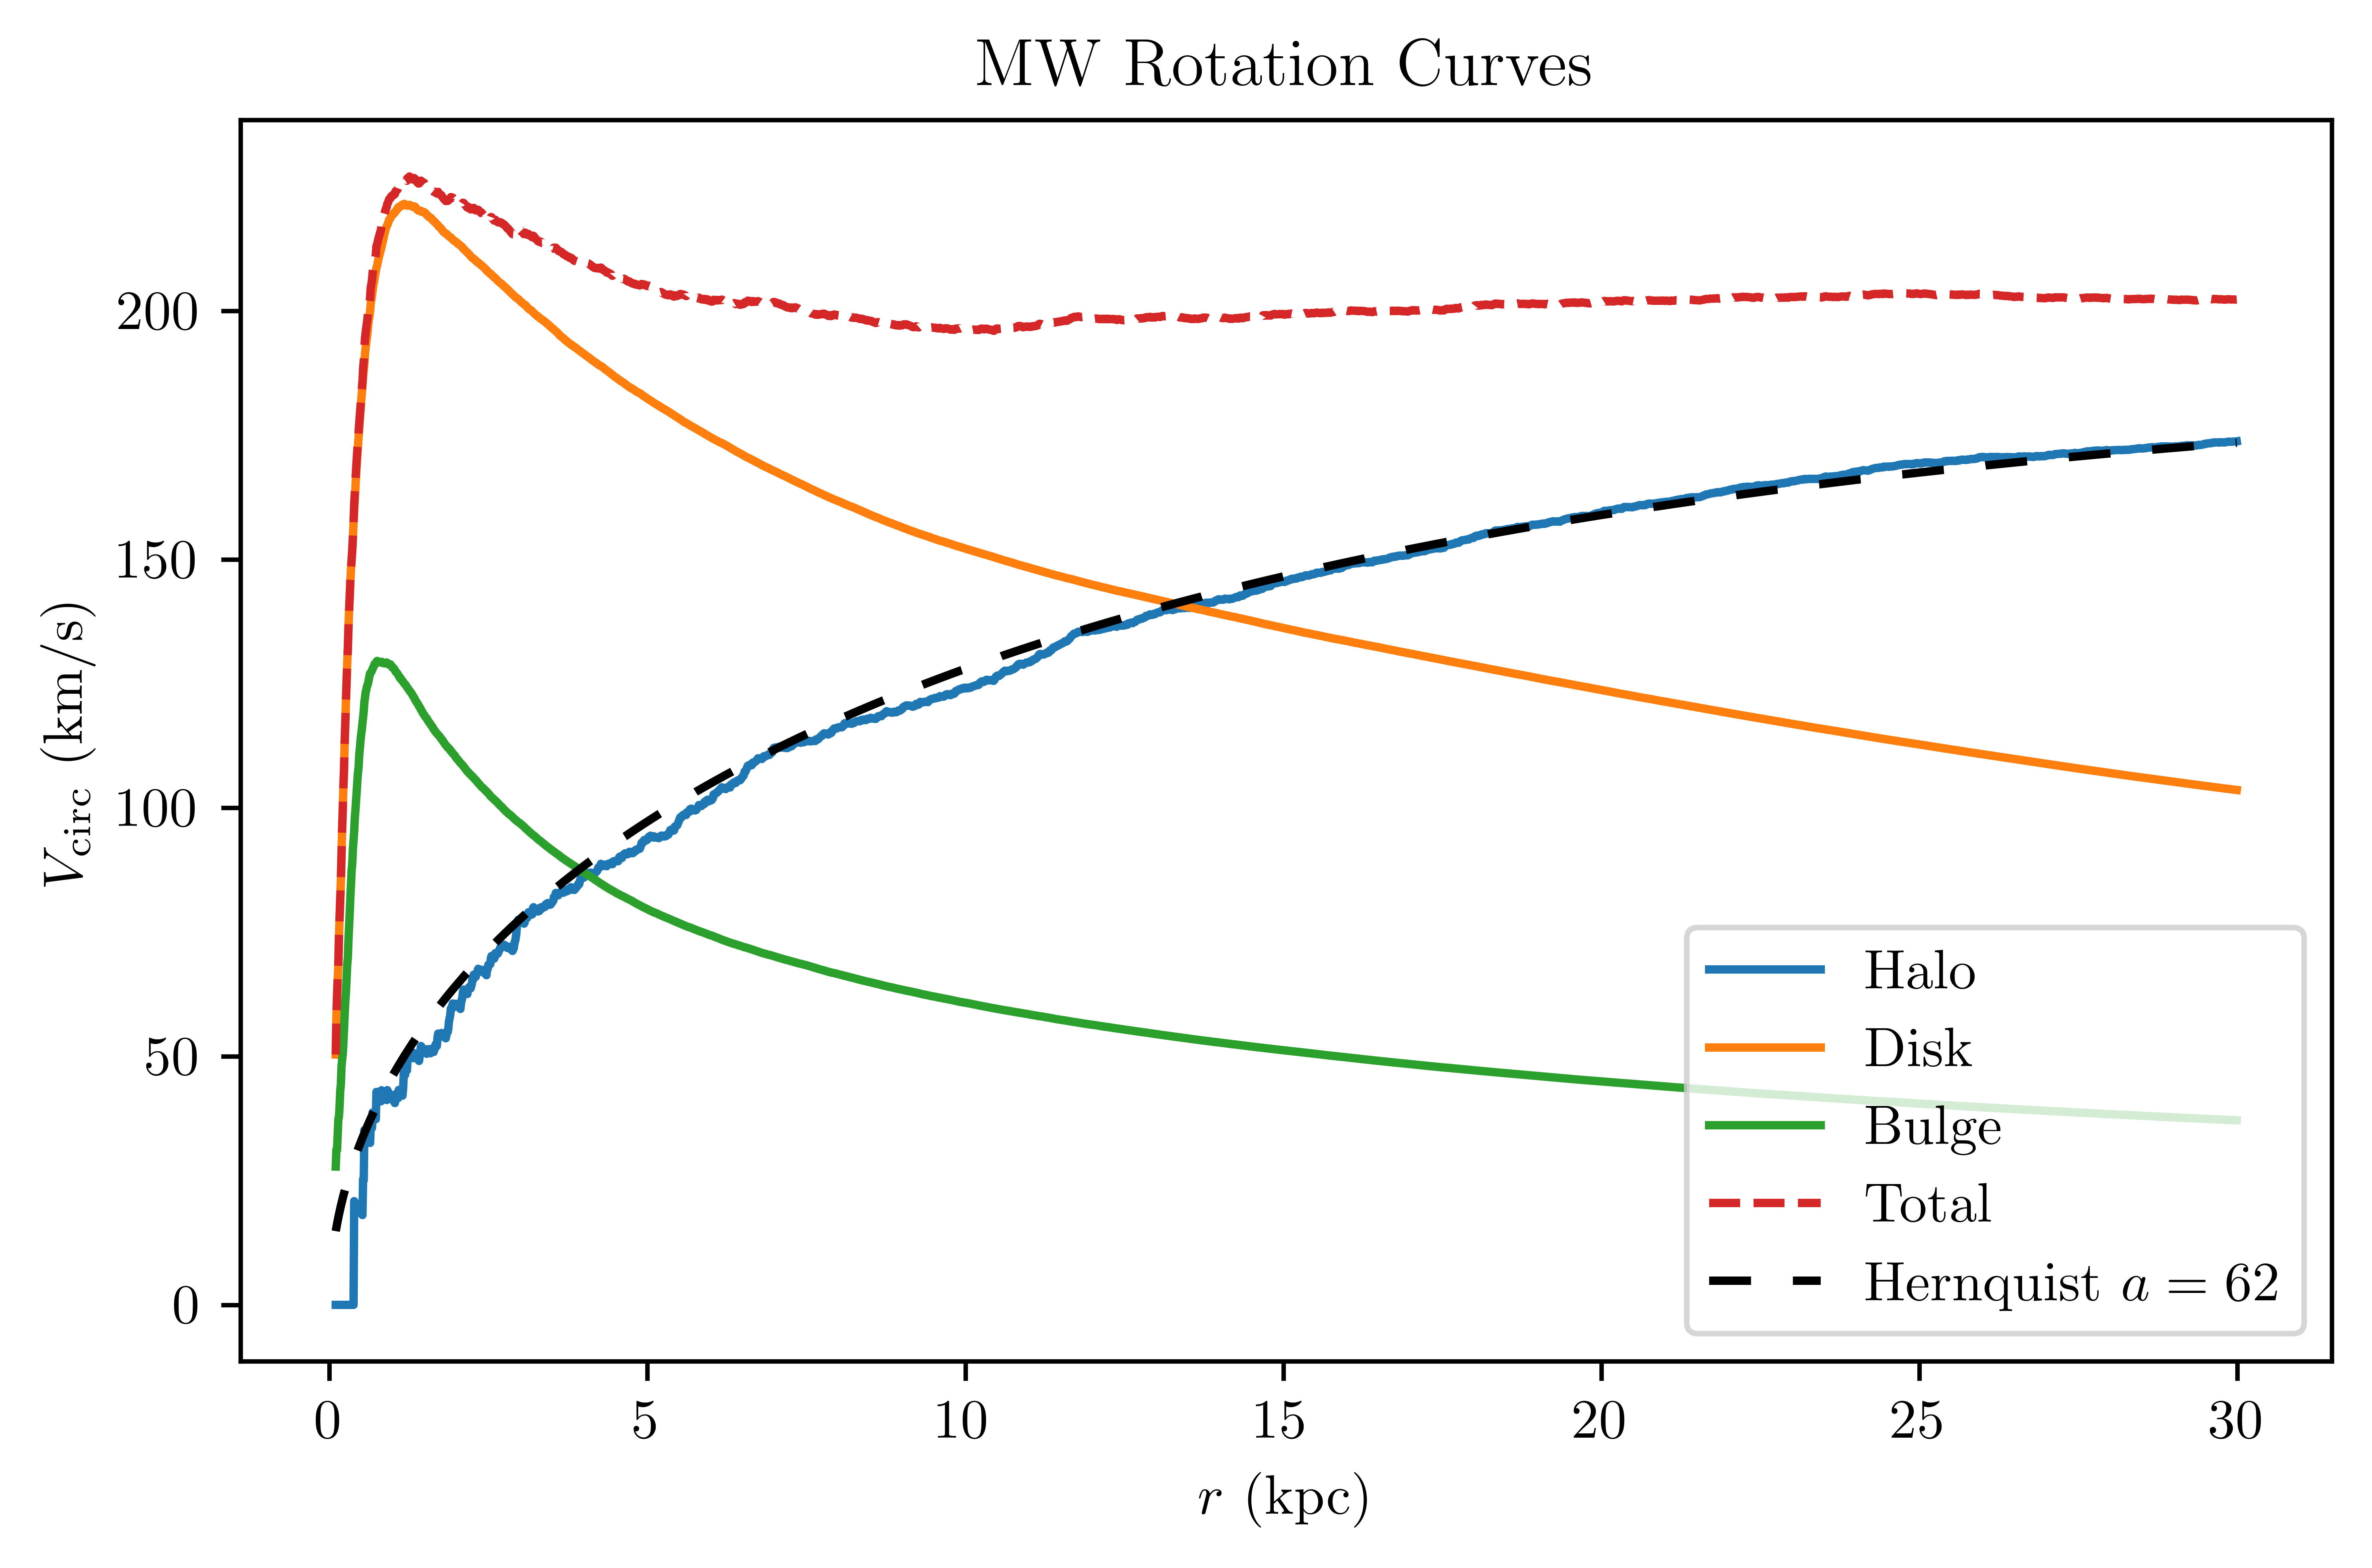

In [24]:
# Setup for plot
fig, ax = plt.subplots()

# Loop through and plot for the different particles (log y-axis)
types = ['Halo', 'Disk', 'Bulge'] # Labels
for i in range(1, 4):
    ax.plot(radii, MW.CircularVelocity(i, radii), label=f'{types[i-1]}')

# Plot the total circular velocity
ax.plot(radii, MW.TotalCircularVelocity(radii), label='Total', linestyle='--')
    
# Plot the best-fit Hernquist profile
ax.plot(radii, MW.HernquistVCirc(radii, a_best_MW, MW_halo),
            label='Hernquist $a = {}$'.format(a_best_MW),
            linestyle=(0, (5, 5)), color='k', linewidth=1.5)

# Legend, labels/title, limits
ax.legend()
ax.set(title=r'MW Rotation Curves', xlabel=r"$r \ (\mathrm{kpc})$",
       ylabel=r'$V_\mathrm{circ} \ (\mathrm{km}/\mathrm{s})$')

# Tidy things up and save the figure as a PNG
fig.tight_layout()
plt.savefig('MW_rotation_curves.png', facecolor='white')

### M33:

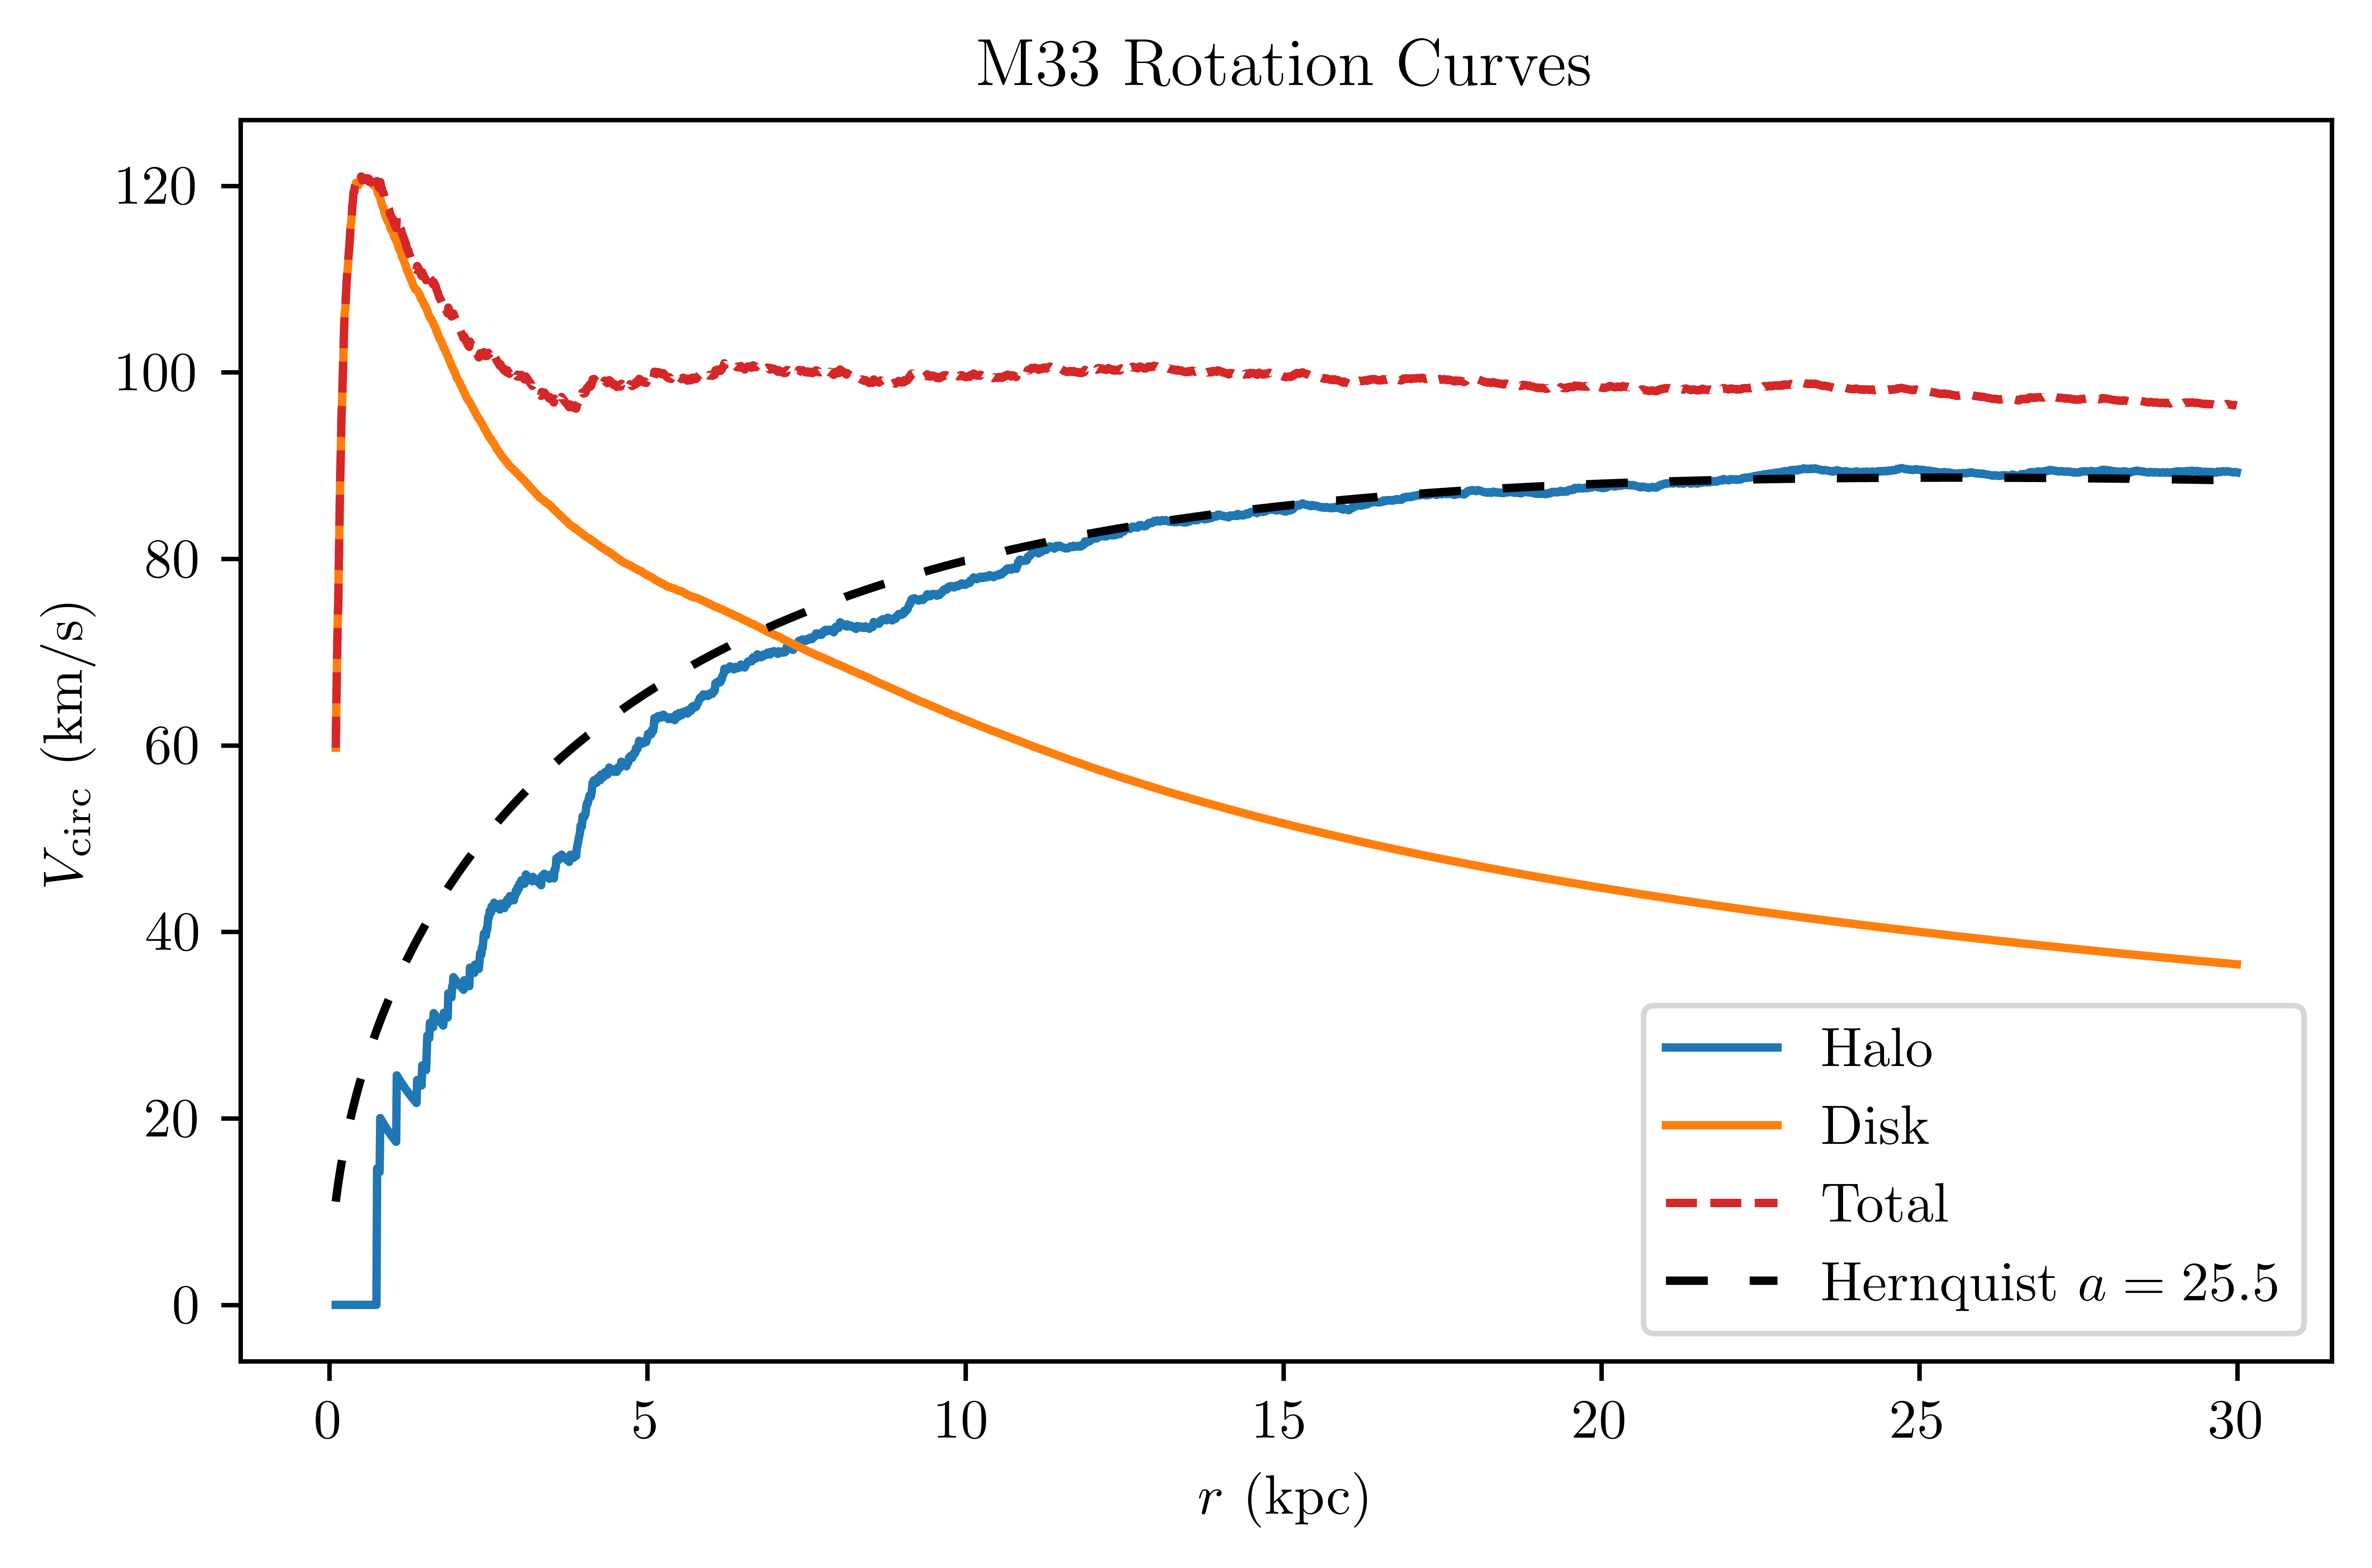

In [25]:
# Setup for plot
fig, ax = plt.subplots()

# Loop through and plot for the different particles (log y-axis)
types = ['Halo', 'Disk'] # Labels, no bulge
for i in range(1, 3):
    ax.plot(radii, M33.CircularVelocity(i, radii), label=f'{types[i-1]}')

# Plot the total circular velocity
ax.plot(radii, M33.TotalCircularVelocity(radii), label='Total', linestyle='--',
       color='C3')# change color to match other rotation curves with bulge
    
# Plot the best-fit Hernquist profile
ax.plot(radii, M33.HernquistVCirc(radii, a_best_M33, M33_halo),
            label='Hernquist $a = {}$'.format(a_best_M33),
            linestyle=(0, (5, 5)), color='k', linewidth=1.5)

# Legend, labels/title, limits
ax.legend()
ax.set(title=r'M33 Rotation Curves', xlabel=r"$r \ (\mathrm{kpc})$",
       ylabel=r'$V_\mathrm{circ} \ (\mathrm{km}/\mathrm{s})$')

# Tidy things up and save the figure as a PNG
fig.tight_layout()
plt.savefig('M33_rotation_curves.png', facecolor='white')

### M31:

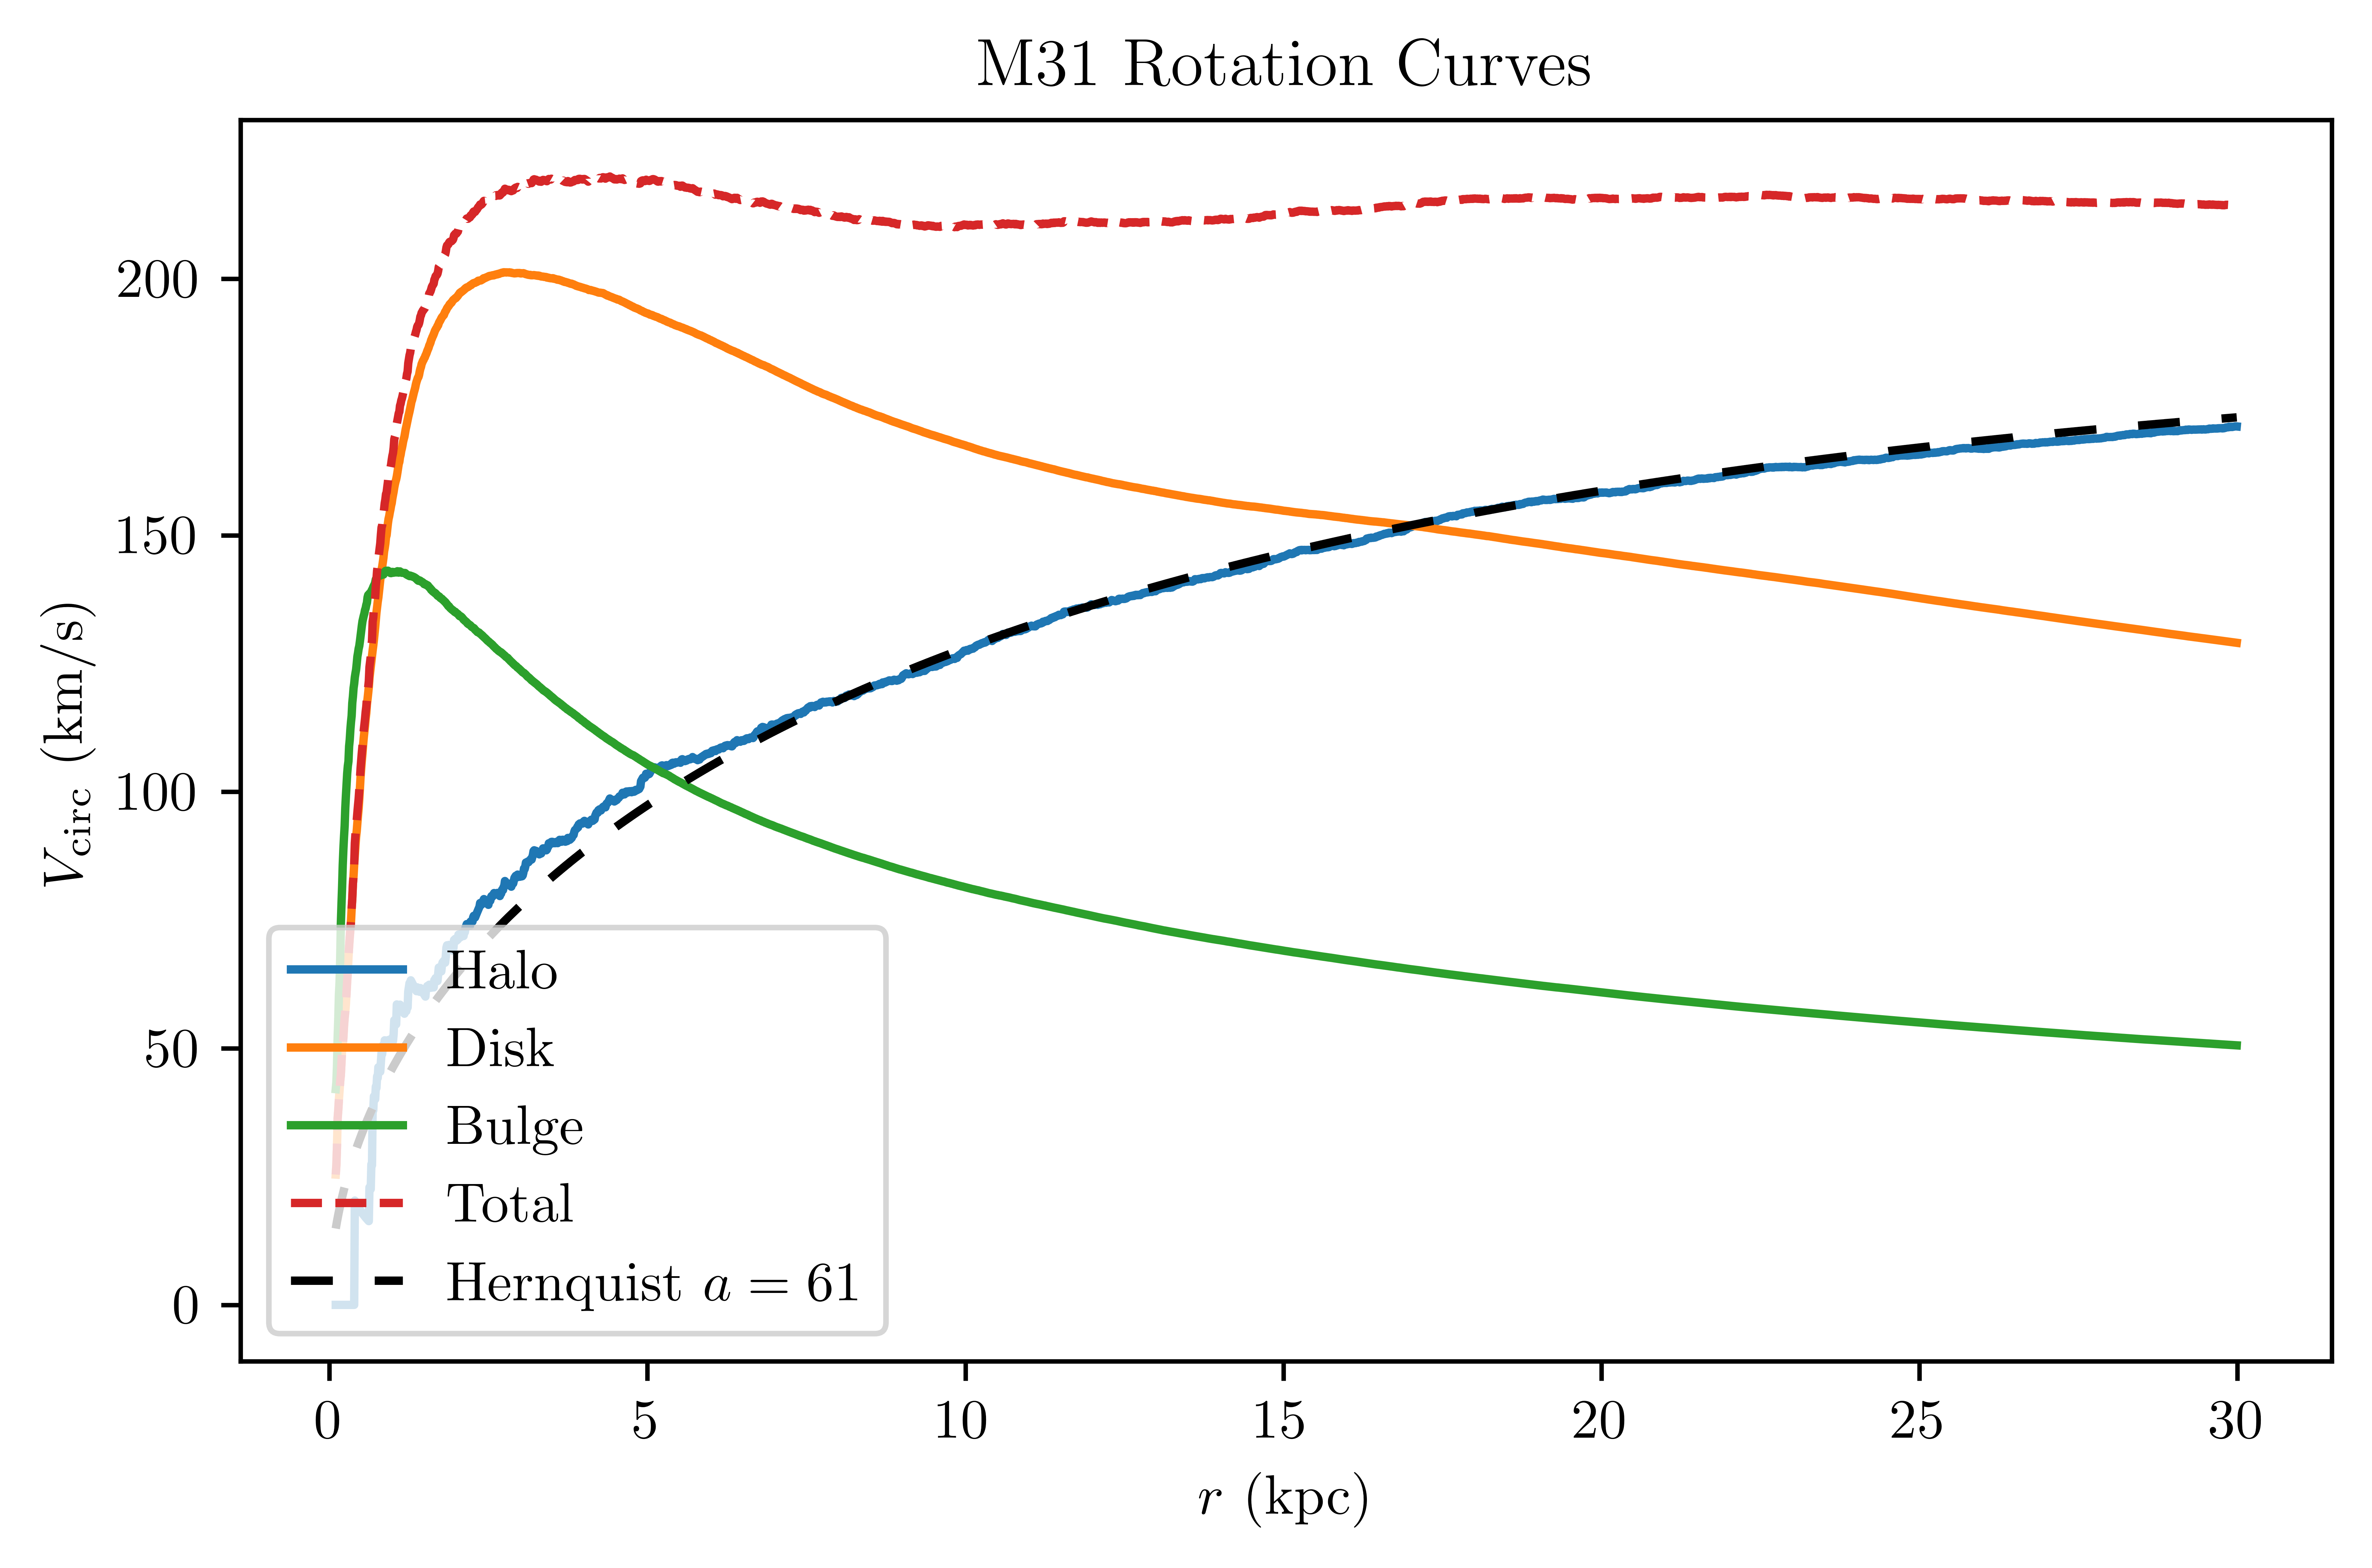

In [26]:
# Setup for plot
fig, ax = plt.subplots()

# Loop through and plot for the different particles (log y-axis)
types = ['Halo', 'Disk', 'Bulge'] # Labels
for i in range(1, 4):
    ax.plot(radii, M31.CircularVelocity(i, radii), label=f'{types[i-1]}')

# Plot the total circular velocity
ax.plot(radii, M31.TotalCircularVelocity(radii), label='Total', linestyle='--')
    
# Plot the best-fit Hernquist profile
ax.plot(radii, M31.HernquistVCirc(radii, a_best_M31, M31_halo),
            label='Hernquist $a = {}$'.format(a_best_M31),
            linestyle=(0, (5, 5)), color='k', linewidth=1.5)

# Legend, labels/title, limits
ax.legend()
ax.set(title=r'M31 Rotation Curves', xlabel=r"$r \ (\mathrm{kpc})$",
       ylabel=r'$V_\mathrm{circ} \ (\mathrm{km}/\mathrm{s})$')

# Tidy things up and save the figure as a PNG
fig.tight_layout()
plt.savefig('M31_rotation_curves.png', facecolor='white')